In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import StratifiedGroupKFold, train_test_split

In [ ]:
df=pd.read_csv("odir/ocular-disease-recognition-odir5k/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
csv_file = "odir/ocular-disease-recognition-odir5k/full_df.csv"
source_image_folder = "odir/ocular-disease-recognition-odir5k/preprocessed_images"
mapped_output_folder = "odir/ocular-disease-recognition-odir5k//ODIR-5K/ODIR-5K/mapped_output"

os.makedirs(mapped_output_folder, exist_ok=True)


df = pd.read_csv(csv_file)
print("CSV Preview:")
print(df.head())


# Mapping images into folders by label
for idx, row in df.iterrows():

    label_str = row['labels']
    label = label_str.strip("[]").replace("'", "").strip()
    file_name = row['filename']

    src_path = os.path.join(source_image_folder, file_name)
    dest_folder = os.path.join(mapped_output_folder, label)
    os.makedirs(dest_folder, exist_ok=True)
    dest_path = os.path.join(dest_folder, file_name)

    if os.path.exists(src_path):
        shutil.copy(src_path, dest_path)
    else:
        print(f"Warning: File not found: {src_path}")

print("Mapping complete. Images have been copied into", mapped_output_folder)


file_paths = []
labels = []
groups = []

#Building file list, labels, and group ids from mapped folder
for class_label in os.listdir(mapped_output_folder):
    class_folder = os.path.join(mapped_output_folder, class_label)
    if os.path.isdir(class_folder):
        print(f"Found class folder: {class_label}")
        for fname in os.listdir(class_folder):
            fpath = os.path.join(class_folder, fname)
            if os.path.isfile(fpath):
                file_paths.append(fpath)
                labels.append(class_label)

                patient_id = fname.split('_')[0]
                groups.append(patient_id)
    else:
        print(f"Skipping {class_label} as it is not a directory.")

file_paths = np.array(file_paths)
labels = np.array(labels)
groups = np.array(groups)

print("Total images found in mapped folder:", len(file_paths))
if len(file_paths) == 0:
    raise ValueError("No images found in mapped folder. Check the folder path/structure.")


# Test Set: 10% of total using StratifiedGroupKFold
n_splits_test = 10
sgkf_test = StratifiedGroupKFold(n_splits=n_splits_test, shuffle=True, random_state=42)


for train_val_idx, test_idx in sgkf_test.split(file_paths, labels, groups):
    break
train_val_paths = file_paths[train_val_idx]
train_val_labels = labels[train_val_idx]
train_val_groups = groups[train_val_idx]

test_paths = file_paths[test_idx]
test_labels = labels[test_idx]

print("After test split:")
print(f"Train+Val images: {len(train_val_paths)}")
print(f"Test images: {len(test_paths)}")

# Split remaining train+validation data by unique groups
unique_groups = {}
for g, lbl in zip(train_val_groups, train_val_labels):
    if g not in unique_groups:
         unique_groups[g] = lbl
group_ids = list(unique_groups.keys())
group_labels = [unique_groups[g] for g in group_ids]

# Train=70% and valid=20%
train_group_ids, valid_group_ids = train_test_split(
    group_ids,
    test_size=0.2222,
    random_state=42,
    stratify=group_labels
)

# Assigning individual images in the train_val set to train or val based on patient id
train_idx_list = [i for i, g in enumerate(train_val_groups) if g in train_group_ids]
valid_idx_list = [i for i, g in enumerate(train_val_groups) if g in valid_group_ids]

train_paths_final = train_val_paths[train_idx_list]
train_labels_final = train_val_labels[train_idx_list]

valid_paths_final = train_val_paths[valid_idx_list]
valid_labels_final = train_val_labels[valid_idx_list]

print("Final group-based split counts:")
print("  Training images:", len(train_paths_final))
print("  Validation images:", len(valid_paths_final))
print("  Test images:", len(test_paths))

group_split_folder = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset"

# Copy files into new folder structure
def copy_files(paths, labels, split_name):
    for fpath, label in zip(paths, labels):
        dest_dir = os.path.join(group_split_folder, split_name, label)
        os.makedirs(dest_dir, exist_ok=True)
        fname = os.path.basename(fpath)
        dest_path = os.path.join(dest_dir, fname)
        shutil.copy(fpath, dest_path)

for split, paths, labs in [("train", train_paths_final, train_labels_final),
                           ("valid", valid_paths_final, valid_labels_final),
                           ("test", test_paths, test_labels)]:
    copy_files(paths, labs, split)

print("Group-based splitting complete. New folder structure created at:", group_split_folder)


CSV Preview:
   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild nonpro

In [ ]:
group_split_folder = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset"

splits = ["train", "valid", "test"]


split_patient_ids = {}
# Loop through each split folder and extract patient IDs from filenames
for split in splits:
    split_path = os.path.join(group_split_folder, split)
    patient_ids = set()

    for class_folder in os.listdir(split_path):
        class_path = os.path.join(split_path, class_folder)
        if os.path.isdir(class_path):
            for fname in os.listdir(class_path):

                patient_id = fname.split('_')[0]
                patient_ids.add(patient_id)
    split_patient_ids[split] = patient_ids
    print(f"{split.capitalize()} split has {len(patient_ids)} unique patient IDs.")

# Checking for overlaps between splits
train_valid_overlap = split_patient_ids["train"].intersection(split_patient_ids["valid"])
train_test_overlap = split_patient_ids["train"].intersection(split_patient_ids["test"])
valid_test_overlap = split_patient_ids["valid"].intersection(split_patient_ids["test"])

print("\nOverlap between Train and Validation patient IDs:", train_valid_overlap)
print("Overlap between Train and Test patient IDs:", train_test_overlap)
print("Overlap between Validation and Test patient IDs:", valid_test_overlap)


Train split has 2349 unique patient IDs.
Valid split has 672 unique patient IDs.
Test split has 337 unique patient IDs.

Overlap between Train and Validation patient IDs: set()
Overlap between Train and Test patient IDs: set()
Overlap between Validation and Test patient IDs: set()


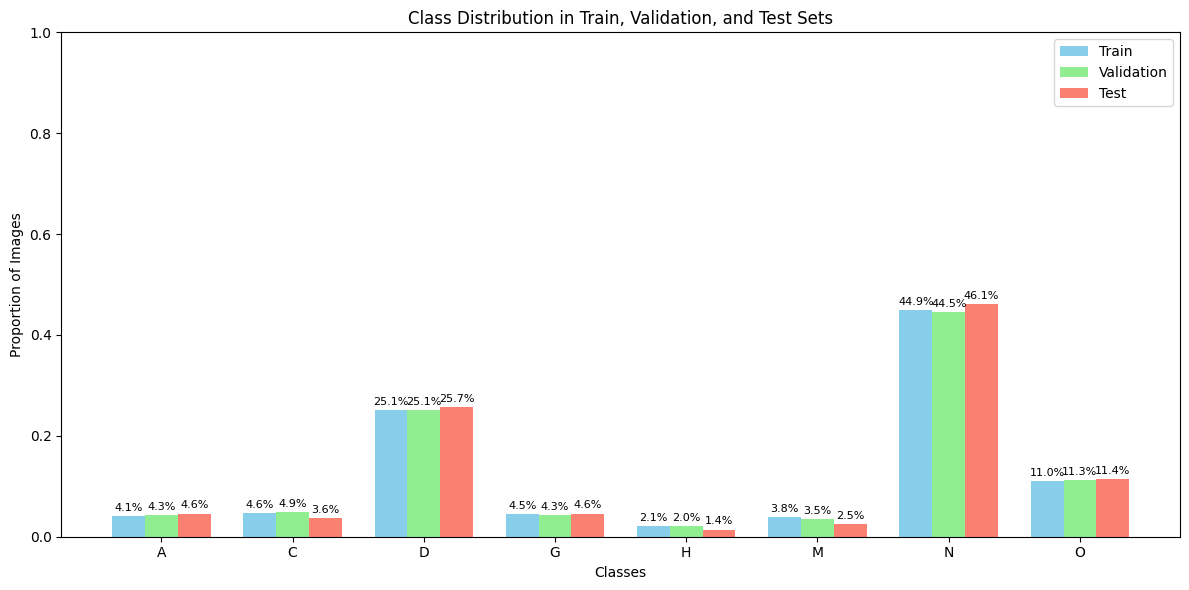

In [ ]:
def get_proportions(folder_path):

    subfolders = [f for f in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, f))]
    image_counts = {}
    total_images = 0

    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        num_images = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
        image_counts[subfolder] = num_images
        total_images += num_images

    proportions = {subfolder: count / total_images if total_images > 0 else 0 for subfolder, count in image_counts.items()}
    return proportions

train_folder = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset/train"
val_folder   = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset/valid"
test_folder  = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset/test"


train_props = get_proportions(train_folder)
val_props   = get_proportions(val_folder)
test_props  = get_proportions(test_folder)


classes = sorted(set(train_props.keys()).union(val_props.keys()).union(test_props.keys()))

# Proportions for eah set
train_values = [train_props.get(cls, 0) for cls in classes]
val_values   = [val_props.get(cls, 0) for cls in classes]
test_values  = [test_props.get(cls, 0) for cls in classes]


x = range(len(classes))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar([i - width for i in x], train_values, width=width, label='Train', color='skyblue')
plt.bar(x, val_values, width=width, label='Validation', color='lightgreen')
plt.bar([i + width for i in x], test_values, width=width, label='Test', color='salmon')

plt.xlabel('Classes')
plt.ylabel('Proportion of Images')
plt.title('Class Distribution in Train, Validation, and Test Sets')
plt.xticks(x, classes)
plt.ylim(0, 1)
plt.legend()

# Percentages on top of bars
for i in x:
    plt.text(i - width, train_values[i] + 0.01, f"{train_values[i]:.1%}", ha='center', fontsize=8)
    plt.text(i, val_values[i] + 0.01, f"{val_values[i]:.1%}", ha='center', fontsize=8)
    plt.text(i + width, test_values[i] + 0.01, f"{test_values[i]:.1%}", ha='center', fontsize=8)

plt.tight_layout()
plt.show()


### CLAHE on one image to view result

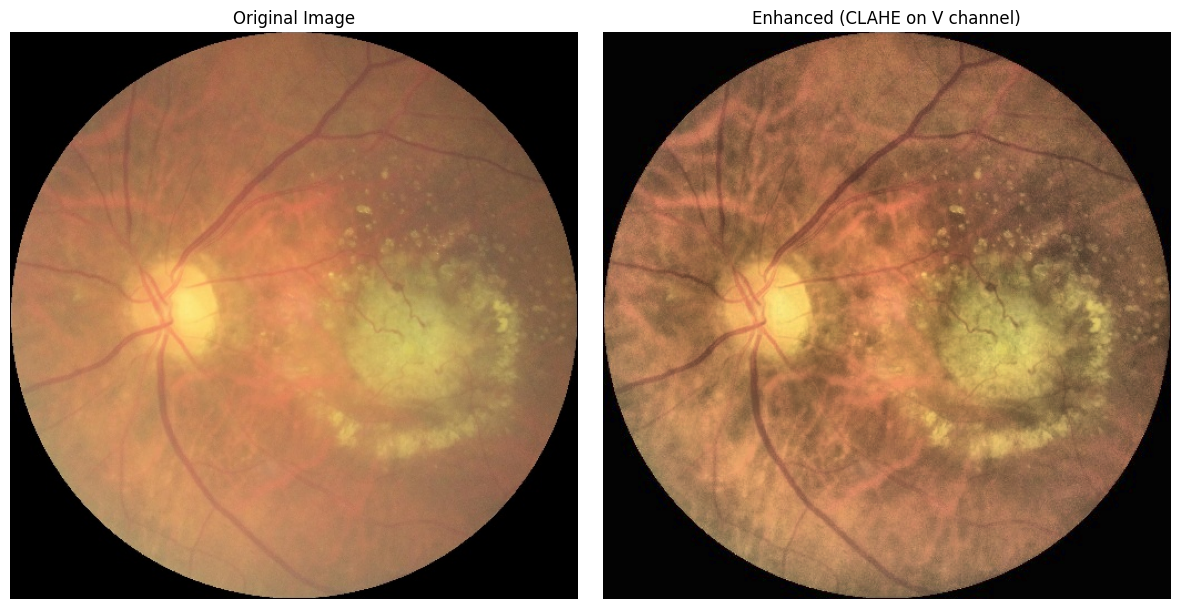

In [ ]:
img = cv2.imread("odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset/test/A/43_left.jpg")
if img is None:
    raise FileNotFoundError("Image not found. Check the image path.")

# Convert image from BGR to RGB for proper color display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the RGB image to HSV color space
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

# Split into Hue, Saturation, Value
h, s, v = cv2.split(img_hsv)

# CLAHE to V channel for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
v_clahe = clahe.apply(v)

# Merge original H and S channels with enhanced V channel
img_hsv_enhanced = cv2.merge((h, s, v_clahe))

# Convert enhanced HSV image back to RGB
img_rgb_enhanced = cv2.cvtColor(img_hsv_enhanced, cv2.COLOR_HSV2RGB)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_rgb_enhanced)
plt.title("Enhanced (CLAHE on V channel)")
plt.axis("off")
plt.tight_layout()
plt.show()


### CLAHE and Rotation on all Train Images


In [ ]:
def preprocess_image(input_path, clipLimit=2.0, tileGridSize=(8,8)):

    img = cv2.imread(input_path)
    if img is None:
        print(f"Error reading image: {input_path}")
        return None

    # Convert image from BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Split into H, S, and V channels
    h, s, v = cv2.split(hsv)

    # Apply CLAHE to V channel
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    v_clahe = clahe.apply(v)

    # Merge channels
    hsv_enhanced = cv2.merge((h, s, v_clahe))

    # Convert enhanced HSV image back to BGR
    processed_img = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

    return processed_img

def augment_rotate(image, angle=3):

    if image is None:
        return None
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)

    #Rotate image by angle degrees around its center
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated


input_split_folder = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/group_split_dataset"
output_split_folder = "odir/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/processed_augmented_group_split_dataset"

os.makedirs(output_split_folder, exist_ok=True)

# Process train, val, test folders
for split in ["train", "valid", "test"]:
    input_split_path = os.path.join(input_split_folder, split)
    output_split_path = os.path.join(output_split_folder, split)
    os.makedirs(output_split_path, exist_ok=True)

    # Subfolders for each class
    for class_name in os.listdir(input_split_path):
        input_class_folder = os.path.join(input_split_path, class_name)
        output_class_folder = os.path.join(output_split_path, class_name)
        os.makedirs(output_class_folder, exist_ok=True)

        # Process each image file in the class folder
        for fname in os.listdir(input_class_folder):
            input_image_path = os.path.join(input_class_folder, fname)

            if os.path.isfile(input_image_path):
                # Apply CLAHE
                processed_img = preprocess_image(input_image_path, clipLimit=2.0, tileGridSize=(8,8))
                if processed_img is None:
                    continue

                output_image_path = os.path.join(output_class_folder, fname)
                cv2.imwrite(output_image_path, processed_img)

                # Apply rotation augmentation by 3 degrees
                rotated_img = augment_rotate(processed_img, angle=3)
                if rotated_img is not None:

                    base, ext = os.path.splitext(fname)
                    rotated_fname = f"{base}_rot3{ext}"
                    output_rotated_path = os.path.join(output_class_folder, rotated_fname)
                    cv2.imwrite(output_rotated_path, rotated_img)

print("Preprocessing and augmentation complete for all split images.")


Preprocessing and augmentation complete for all split images.
